In [1]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *

import sys

In [8]:
class interface(QWidget):
    """
    This is my widget.
    """
    def __init__(self):
        super().__init__()
        
        #layout principal
        self.global_layout = QHBoxLayout(self)
        
        self.tab_widget = QTabWidget(self)
        self.tab1 = child_widget_1(self.tab_widget)
        self.tab_widget.addTab(self.tab1,"Live Mode")
        
        self.tab2 = child_widget_2(self.tab_widget)
        self.tab_widget.addTab(self.tab2,"Calibration Mode")
        
        shadow1 = QGraphicsDropShadowEffect(xOffset=3,yOffset=3,blurRadius=5,color=Qt.black)
        self.tab_widget.setGraphicsEffect(shadow1)
        
        self.global_layout.addWidget(self.tab_widget)
        
################################################################### 

class child_widget_1(QWidget):
    
    def __init__(self, parent=None):
        super().__init__(parent)
        mainLayout=QBoxLayout(self)
        
    def laser_widget():
        return 0
###################################################################        

class child_widget_2(QWidget):
    def __init__(self, parent=None):
        super().__init__(parent=parent)
        
        self.global_layout = QHBoxLayout(self)
        
        
###################################################################

qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = interface()
    #show the widget
    ui.show()
    #start the event loop
    qapp.exec_()

TypeError: QBoxLayout(QBoxLayout.Direction, parent: QWidget = None): argument 1 has unexpected type 'child_widget_1'

# Camera

#### Automatic trapping

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import io
from skimage.filters import threshold_local
from skimage.segmentation import clear_border
from skimage.morphology import binary_closing, square
from skimage.measure import label, regionprops
from skimage.color import rgb2gray, label2rgb

class AutomaticTrapper():
    def __init__(self, area=30*30):
        self.target_area = area # area of target particles, in pixels
        self.fig = plt.figure(figsize=(8, 8), dpi=50)
        self.ax = self.fig.add_subplot()

        self.image = None 
        self.displacement = None
        self.detected_centroids = None

        ############# CONSTANTS ######################
        self.pixel_per_micron = 16 # pixel/micrometer
        self.voltage_per_micron = 3 # volt/micrometer (piezoelectrics)
        
        ############# TRAP LOCATION ######################
        self.trap_pos = np.array([33.1, 35.6]) # micrometer, relative to image top left corner
        self.trap_ind = (self.trap_pos * self.pixel_per_micron).astype(int) # indexes
        print("trap index", self.trap_ind)

        ################# REGION OF INTEREST ################
        self.roi_size = int(18 * self.pixel_per_micron) # size of rectangle, in pixels
        self.roi_topleft_corner = self.trap_ind - self.roi_size*np.array([1, 0])
        self.roi_bottomright_corner = self.trap_ind + self.roi_size*np.array([0, 1])
        
        self.rectangle_params = self.calculate_rect(self.roi_topleft_corner,
                                                    self.roi_bottomright_corner,
                                                    alt=True)
        self.particle_params = []


        ############## PIEZOELECTRIC ###################
        self.piezo_voltage = np.zeros(2) # [Vx, Vy]

    def acquire(self, frame):
        """
        Retrieve the image data
        """
        ######################## PRE-PROCESS IMAGE ###############################
        if frame.shape[-1] == 4:
            frame = frame[:, :, :-1] # drop alpha channel
        self.particle_params.clear()
        return rgb2gray(frame) # convert to gray scale
    
    def segment(self, img):
        """
        Apply segmentation to locate particles in given image 
        """
        #################### SEGMENTATION ALGORITHM ############################
        # apply local threshold
        mask = threshold_local(img, method="gaussian", block_size=35)
        # close regions that have small tears on their boundary
        closed = binary_closing(img > mask, square(3))
        # remove everything that is not a closed region and is connected to the edges
        processed = clear_border(closed)
        # label segmented regions
        image_label = label(processed)
        return image_label
    
    def calculate_rect(self, tl, br, get_slice=False, alt=False):
        """
        Wrapper for obtaining parameters for rectangle drawing
        """
        minr, minc, maxr, maxc = tl[0], tl[1], br[0], br[1]
        w, h = maxc - minc, maxr - minr
        if get_slice:
            sx, sy = slice(minr, maxr), slice(minc, maxc)
            return sx, sy
        elif alt:
            return (minc, minr, w, h)
        else:
            return (maxc, maxr, w, h)
    
    def calculate_RoI(self):
        """
        Update RoI dynamically in order to maximize actuation area
        """
        ##################### INITIALIZE RoI ########################
        # default RoI
        if self.displacement is None:
            i, j = tuple(self.trap_ind)
            sx, sy = slice(i - self.roi_size, i), slice(j, j + self.roi_size)
            #print(sx, sy)
            return sx, sy

        else:
            tl = self.roi_topleft_corner + self.displacement
            br = self.roi_bottomright_corner + self.displacement

            self.rectangle_params = self.calculate_rect(tl, br, alt=True)
            sx, sy = self.calculate_rect(tl, br, get_slice=True)
            #print(sx, sy)
            return sx, sy
    
    def process_image(self, frame):
        """
        If called without arguments, locates particle inside default RoI
        Else, updates RoI with latest piezo output and locates particle inside the new RoI
        """
        self.image = self.acquire(frame)
        sx, sy = self.calculate_RoI()
        label = self.segment(self.image[sx, sy]) # only segment the RoI 
        return label

    def locate_particle(self, image_label):
        """
        Given the segmented image, chooses one particle inside it, satisfying minimum area requirement
        """
        positions = [] 
        regions = regionprops(image_label)

        for region in regions:
            # skip if the region is too small
            if region.area < self.target_area:
                continue
            # indexes relative to the top left corner of cropped image
            minr, minc, maxr, maxc = region.bbox
            
            tl = np.array([minr, minc]) + self.roi_topleft_corner
            br = np.array([maxr, maxc]) + self.roi_topleft_corner
            if self.displacement is not None:
                tl += self.displacement
                br += self.displacement
            temp = self.calculate_rect(tl, br, alt=True)
            self.particle_params.append(temp) 
            
            centroid = (0.5*(tl + br)).astype(int)
            positions.append(centroid)

        positions = np.array(positions)
        if positions.size < 1:
            return None # no particles found
        return positions 
    
    def pz_response(self, pos, flag=False):
        """
        Given the particle location (in the image), computes the required piezoelectric voltage 
        to bring the particle to the trap's position
        """
        if pos is None:
            return None # no particles found, skip
        # print("my particle pos", positions)
        # pos = positions[0, :] # select the first particle among the detected
        # print("first pos", pos, type(pos))
        ind_diff = pos - self.trap_ind # calculate how many pixels away the particle is from the trap's position
        if flag:
            ind_diff *= -1
        # print(ind_diff)
        if self.displacement is not None:
            self.displacement += ind_diff.copy() # update value for new RoI (should be rigidly shifted by this value)
        else:
            self.displacement = ind_diff.copy()
        distance_diff = ind_diff / self.pixel_per_micron # convert the pixel difference to distance
        required_voltage = distance_diff * self.voltage_per_micron # calculate required piezo voltage for this displacement
        required_voltage[1] *= -1
        self.piezo_voltage = required_voltage # keeps track of the total piezo increments so far
        # print("total piezo voltage", self.piezo_voltage)
        return required_voltage
    
    def scan(self, frame):
        # Acquire image, intialize/update RoI, segment the cropped image
        image_label = self.process_image(frame=frame)
        # Get particle indexes relative to complete image, from segmented image
        positions = self.locate_particle(image_label)
        self.detected_centroids = positions
        
    def trap(self, pos, automatic=False):
        """
        Give position of the centroid of desired particle
        """
        if automatic: # fetch a particle among the detected
            pz_output = self.pz_response(self.detected_centroids[0, :], flag=automatic) 
        else: # recieve particle positio from mouse click
            pz_output = self.pz_response(pos)
        if pz_output is not None:
            # print("volt", pz_output)
            # print("pixel", pz_output / self.voltage_per_micron * self.pixel_per_micron)
            self.calculate_RoI()
        return pz_output


trap index [529 569]
Detecetd devices... ['29500489', '29500495', '29500501', '69250571', '84868288', '84868295']
Establishing connection...
Device 29500489 has been connected!
Device 29500495 has been connected!
Piezo voltage before closing: (0.0251777703176977, 0.0892666402172918) V
Disconnected device 29500489
Disconnected device 29500495


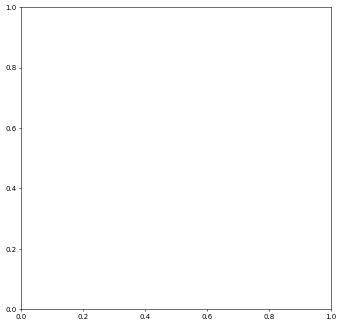

In [2]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from pylablib.devices import uc480 #uc480 dll's needed
import cv2
import sys
import numpy as np
from live import LiveFeed
import time
# for moving the stage automatically
import piezos

class WorkerSignals(QObject):
    
    finished = pyqtSignal()
    data = pyqtSignal(list)
    voltage = pyqtSignal(list)

class camera_widget(QWidget):
    
    def __init__(self):
        super().__init__()
        self.autotrap = AutomaticTrapper() 
        self.data=[(0, 0, 0, 0), []]
        self.pool = QThreadPool()


        self.setWindowTitle("Camera")
        self.disply_width = 1280
        self.width_scaling = self.disply_width/1280
        self.display_height = 1024
        self.height_scaling = self.display_height/1024
        self.width_scaler = lambda x : int(self.width_scaling * x)
        self.height_scaler = lambda x : int(self.height_scaling * x) 
        # create the label that holds the image
        self.image_label = ImageLabel(self)
        self.image_label.clicked.connect(self.select_particle)
        self.image_label.resize(self.disply_width, self.display_height)
        # create a text label
        self.textLabel = QLabel('Camera')
        # create a vertical box layout and add the two labels
        vbox = QVBoxLayout()
        vbox.addWidget(self.image_label)
        vbox.addWidget(self.textLabel)
        # create a horizontal box layout for buttons
        #butbox = QHBoxLayout()
        #vbox.addLayout(butbox)
        # set the vbox layout as the widgets layout
        self.setLayout(vbox)

        # button for reading piezo
        self.pz_button = QToolButton(self)
        self.pz_button.setText("Read voltage")
        self.pz_button.clicked.connect(self.read_piezo)
        # label for displaying result
        self.pz_label = QLabel(self)
        self.pz_label.setText(f"Vx = {'--'}, Vy = {'--'}")
        
        # button for trapping
        self.trap_button = QToolButton(self)
        self.trap_button.setText('Trap Particle')
        # self.trap_button.clicked.connect(self.request_trap)
        
        # checkbox for enabling trap mode
        #self.checkbox = QCheckBox(self)
        
        #butbox.addWidget(self.checkbox)
        vbox.addWidget(self.pz_button)
        vbox.addWidget(self.pz_label)
        vbox.addWidget(self.trap_button)
        
        # initialize piezos
        print("Detecetd devices...", piezos.list_devices())
        self.px = piezos.KPZ("29500489") # ok
        self.py = piezos.KPZ("29500495") # piezo was faulty, changed y <-> z
        print("Establishing connection...")
        self.px.connect()
        self.py.connect()
        
        # create the video capture thread
        self.thread = LiveFeed()
        # connect its signal to the update_image slot
        self.thread.change_pixmap_signal.connect(self.update_image)
        # start the thread
        self.thread.start()

    def request_trap(self, pos):
        print("Trapping...")
        worker = RunnableTrap(self.autotrap, pos)
        worker.signals.data.connect(self.update_data)
        worker.signals.voltage.connect(self.update_piezo)
        # piezo:  if voltage > 0, pz = voltage
        #         if voltage < 0, pz = pz - |voltage|
        worker.signals.finished.connect(self.everything_is_fine)
        self.pool.start(worker)
    
    def select_particle(self, pos):
        for particle in self.data[1]:
            x, y, w, h = particle
            if (x < pos[0] < x + h) and (y < pos[1] < y + w):
                self.request_trap((int(x + 0.5*h), int(y + 0.5*w)))
                print("Requested trapping...")
                break
       
    def read_piezo(self):
        curr_vx = self.px.get_output_voltages()
        curr_vy = self.py.get_output_voltages()
        self.pz_label.setText(f"Vx = {curr_vx:.2f}, Vy= {curr_vy:.2f}")
    
    def update_piezo(self, voltages):
        vx = voltages[0]; vy = voltages[1]
        print(f"Input voltages: {vx, vy} V")
        curr_vx = self.px.get_output_voltages()
        curr_vy = self.py.get_output_voltages()
        
        new_vx = (curr_vx + vx if vx > 0 else curr_vx - abs(vx))
        new_vy = (curr_vx + vy if vy > 0 else curr_vy - abs(vy))
        
        if new_vx > 60 or new_vy > 60:
            print(f"Voltages are saturated! Current voltage: {curr_vx, curr_vy} V")
        else:
            print(f"Updating voltage to values {new_vx, new_vy} V")
            print("Moving stage...")
            self.px.set_output_voltages(int(new_vx))
            self.py.set_output_voltages(int(new_vy))
            time.sleep(0.2)
            curr_vx = self.px.get_output_voltages()
            curr_vy = self.py.get_output_voltages()
            print(f"Stage has moved. Current voltage: {curr_vx, curr_vy} V")     

    
    def update_data(self,data_t):
        self.data = data_t
    
    def everything_is_fine(self):
        pass
    
    def closeEvent(self, event):
        self.thread.stop()
        self.px.set_output_voltages(0.1)
        self.py.set_output_voltages(0.1)
        time.sleep(1)
        curr_vx = self.px.get_output_voltages()
        curr_vy = self.py.get_output_voltages()
        print(f"Piezo voltage before closing: {curr_vx, curr_vy} V")     
        self.px.close()
        self.py.close()
        event.accept()

    #@pyqtSlot(np.ndarray)
    def update_image(self, frame):
        """Updates the image_label with a new opencv image"""
       
        qt_img = self.convert_cv_qt(frame)
        painter = QPainter(qt_img)
        pen = QPen()
        #pen.setWidth(10)
        pen.setColor(QColor('red'))
        painter.setPen(pen)
        painter.drawLine(0, 530, 1280, 530)
        painter.drawLine(569, 0, 569, 1024)
        painter.end()
        #print(self.flag_trap)
        if self.pool.activeThreadCount() < 1:
            worker = RunnableScan(frame, self.autotrap)
            worker.signals.data.connect(self.update_data)
            worker.signals.finished.connect(self.everything_is_fine)
            self.pool.start(worker)

        # draw ROI rectangle
        painter = QPainter(qt_img)
        pen = QPen()
        pen.setWidth(4)
        pen.setColor(QColor('red'))
        painter.setPen(pen)
        a, b, c, d = self.data[0]
        a = self.width_scaler(a); c = self.width_scaler(c)
        b = self.height_scaler(b); d = self.height_scaler(d)
        painter.drawRect(a, b, c, d)
        painter.end()

        # draw rectangle around particles
        painter = QPainter(qt_img)
        pen = QPen()
        pen.setColor(QColor('blue'))
        painter.setPen(pen)
        for rect in self.data[1]:
            a, b, c, d = rect
            a = self.width_scaler(a); c = self.width_scaler(c)
            b = self.height_scaler(b); d = self.height_scaler(d)
            painter.drawRect(a, b, c, d)
        painter.end()

        #print(t2-t1)
        
        self.image_label.setPixmap(qt_img)
       
    def convert_cv_qt(self, frame):
        """Convert from an opencv image to QPixmap"""
        rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h, w, ch = rgb_image.shape
        bytes_per_line = ch * w
        convert_to_Qt_format = QImage(rgb_image.data, w, h, bytes_per_line, QImage.Format_RGB888)
        p = convert_to_Qt_format.scaled(self.disply_width, self.display_height, Qt.KeepAspectRatio)
        return QPixmap.fromImage(p)

class RunnableScan(QRunnable):
    
    def __init__(self,frame,auto):
        super().__init__()
        self.frame=frame
        self.auto=auto
        self.signals = WorkerSignals()
    
    @pyqtSlot()
    def run(self):

        response=self.auto.scan(self.frame)
        self.signals.data.emit([self.auto.rectangle_params, self.auto.particle_params])
        self.signals.finished.emit()

class RunnableTrap(QRunnable):
    
    def __init__(self, auto, pos):
        super().__init__()
        self.auto = auto
        self.pos = pos
        self.signals = WorkerSignals()
    
    @pyqtSlot()
    def run(self):
        print("before .trap():", self.auto.rectangle_params)
        response = self.auto.trap(self.pos)
        if response is None:
            print("No particles detected!")
        else:    
            print("after .trap():", self.auto.rectangle_params)
            print("trap index", self.auto.trap_ind)
            self.signals.data.emit([self.auto.rectangle_params, self.auto.particle_params])
            self.signals.voltage.emit(list(response))
            self.signals.finished.emit()
            
class ImageLabel(QLabel):
    
    clicked = pyqtSignal(tuple)
    def __init__(self, rect):
        super().__init__()
        
    def mousePressEvent(self, event):
        x = event.pos().x()
        y = event.pos().y()
        print(x,y)
        self.clicked.emit((x, y))
        

qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)

if __name__ == "__main__": 
    #start the widget
    ui = camera_widget()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

# Sidebar Widget

In [25]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
import time

import sys

class sidebar_widget(QWidget):
    
    def __init__(self, parent=None):
        super().__init__(parent)
        
        sizePolicy=QSizePolicy(QSizePolicy.Expanding,QSizePolicy.Minimum)
        
        self.global_layout = QVBoxLayout(self)
        
        self.live_button=QToolButton(self)
        self.live_button.setText('Live Mode')
        self.live_button.setSizePolicy(sizePolicy)
        self.global_layout.addWidget(self.live_button)
        
        self.calibration_button=QToolButton(self)
        self.calibration_button.setSizePolicy(sizePolicy)
        self.calibration_button.setText('Calibration Mode')
        self.global_layout.addWidget(self.calibration_button)
    
        self.classification_button=QToolButton(self)
        self.classification_button.setSizePolicy(sizePolicy)
        self.classification_button.setText('Classification Mode')
        self.global_layout.addWidget(self.classification_button)
        
        spacer=QSpacerItem(40,40,QSizePolicy.Minimum,QSizePolicy.Expanding)
        self.global_layout.addItem(spacer)
        
        self.settings_button=QToolButton(self)
        self.settings_button.setSizePolicy(sizePolicy)
        self.settings_button.setText('Settings')
        self.global_layout.addWidget(self.settings_button)
        
        self.setFixedWidth(100)
        
        
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = sidebar_widget()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

# Laser

In [ ]:
from PyQt5.QtCore import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
import time
import queue
from laser_utils.send_requests import req_Worker
from laser_utils.event_handler import Worker
from laser_utils.laser_Copy1 import mwLaser
#import breeze_resources

import sys

class laser_widget(QWidget):
    """
    This is my widget.
    """
    def __init__(self, parent=None):
        
        super().__init__()
        
        self.global_layout = QGridLayout(self)
        
        self.laser=mwLaser() ##laser driver
        
        self.q = queue.Queue(maxsize=20) ## Event queue
        
        #######################################################laser box
        container_laser=QGroupBox("Laser")
        vbox_laser= QVBoxLayout(container_laser)
        
        containersimple=QGroupBox()
        hboxsimple=QHBoxLayout(containersimple)
        self.current_display=QLCDNumber(self)
        self.current_display.setGeometry(QRect())
        hboxsimple.addWidget(self.current_display)
        self.labelmAl=QLabel(self)
        self.labelmAl.setText('mA')
        hboxsimple.addWidget(self.labelmAl)
        vbox_laser.addWidget(containersimple)
        
        containersimple1=QGroupBox()
        hboxsimple1=QHBoxLayout(containersimple1)
        self.power_display=QLCDNumber(self)
        self.power_display.setGeometry(QRect())
        hboxsimple1.addWidget(self.power_display)
        self.labelmW=QLabel(self)
        self.labelmW.setText('mW')
        hboxsimple1.addWidget(self.labelmW)
        hboxsimple1.addWidget(containersimple1)
        vbox_laser.addWidget(containersimple1)
        
        ################################################TEC box
        container_TEC=QGroupBox("TEC")
        vbox_TEC= QVBoxLayout(container_TEC)
        containersimple2=QGroupBox()
        
        hboxsimple2=QHBoxLayout(containersimple2)
        self.temp_display=QLCDNumber(self)
        self.temp_display.setGeometry(QRect())
        hboxsimple2.addWidget(self.temp_display)
        self.labelC=QLabel(self)
        self.labelC.setText('ºC')
        hboxsimple2.addWidget(self.labelC)
        vbox_TEC.addWidget(containersimple2)
        
        containersimple3=QGroupBox()
        hboxsimple3=QHBoxLayout(containersimple3)
        self.currTEC_display=QLCDNumber(self)
        self.currTEC_display.setGeometry(QRect())
        hboxsimple3.addWidget(self.currTEC_display)
        self.labelmATEC=QLabel(self)
        self.labelmATEC.setText('mA')
        hboxsimple3.addWidget(self.labelmATEC)
        vbox_TEC.addWidget(containersimple3)
        
        ###############################################current control
        container_input=QGroupBox("Laser Setpoint")
        hbox_set= QHBoxLayout(container_input)
        
        self.labelcur=QLabel(self)
        self.labelcur.setText('Current setpoint:')
        hbox_set.addWidget(self.labelcur)
        
        self.currentv=QLineEdit(self)
        self.currentv.setText('50')
        self.currentv.returnPressed.connect(self.current_changed)
        hbox_set.addWidget(self.currentv)
        
        self.labelmA=QLabel(self)
        self.labelmA.setText('mA')
        hbox_set.addWidget(self.labelmA)
        
        ##################################################temp control
        container_inputt=QGroupBox("TEC Setpoint")
        hbox_set1= QHBoxLayout(container_inputt)
        
        self.labeltemps=QLabel(self)
        self.labeltemps.setText('Temperature setpoint:')
        hbox_set1.addWidget(self.labeltemps)
        
        self.temperaturev=QLineEdit(self)
        self.temperaturev.setText('25')
        self.temperaturev.returnPressed.connect(self.temp_changed)
        hbox_set1.addWidget(self.temperaturev)
        
        self.labelC=QLabel(self)
        self.labelC.setText('ºC')
        hbox_set1.addWidget(self.labelC)
        
        ########################################################buttons
        container_button=QGroupBox()
        hbox_set2= QHBoxLayout(container_button)
        
        self.turn_on_button=QToolButton(self)
        self.turn_on_button.setText('Start Laser')
        self.turn_on_button.clicked.connect(self.laser_clicked)
        #self.turn_on_button.clicked.connect(self.button_state)
        
        container_button2=QGroupBox()
        hbox_set3= QHBoxLayout(container_button2)
        
        self.shutdown_button=QToolButton(self)
        self.shutdown_button.setText('Shutdown')
        self.shutdown_button.clicked.connect(self.shutdown)
        #self.shutdown_button.clicked.connect(self.button_state)
        
        hbox_set2.addWidget(self.turn_on_button)
        hbox_set3.addWidget(self.shutdown_button)

        ######################################################global
        
        self.global_layout.addWidget(container_laser,0,0)
        self.global_layout.addWidget(container_TEC,0,1)
        self.global_layout.addWidget(container_input,1,0)
        self.global_layout.addWidget(container_inputt,1,1)
        self.global_layout.addWidget(container_button,2,1)
        self.global_layout.addWidget(container_button2,2,0)
        
        #self.setFixedWidth(100)
        #self.setFixedHeight(200)
    ###########################################################functions
    #### initial state   
        self.request_thread()
        self.thread()
        #self.button_state()
    #### initiate thread and change status
    
    def thread(self):
        self.thread=QThread()
        self.worker=Worker(self.q,self.laser)
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.update)
        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.thread.finished.connect(self.thread.deleteLater)
        self.worker.data.connect(self.update_status)
        self.thread.start()
    
    def request_thread(self):
        self.reqthread=QThread()
        self.reqworker=req_Worker(self.q)
        self.reqworker.moveToThread(self.reqthread)
        self.reqthread.started.connect(self.reqworker.ask)
        self.reqworker.finished.connect(self.reqthread.quit)
        self.reqworker.finished.connect(self.reqworker.deleteLater)
        self.reqthread.finished.connect(self.reqthread.deleteLater)
        #self.reqworker.data.connect(self.results)
        self.reqthread.start()
    
    
    #### get status from laser class
    def update_status(self,data_retrieved):
        self.laser.current = data_retrieved[0]
        self.laser.power = data_retrieved[1]
        self.laser.TEC_temperature = data_retrieved[2]
        self.laser.TEC_curent=data_retrieved[3]
        self.laser.status=data_retrieved[4]
        self.update_laser_values()
    
    #### 
    def update_laser_values(self):
        self.current_display.display(self.laser.current)
        self.power_display.display(self.laser.power)
        self.currTEC_display.display(self.laser.TEC_current)
        self.temp_display.display(self.laser.TEC_temperature)
        self.status=self.laser.status
        self.button_state()
        
    def button_state(self):
        if self.status=='Disabled' or self.status=='Ready':
            self.turn_on_button.setText('Start Laser')
             
        elif self.status=='Active':
            self.turn_on_button.setText('Disable')

        elif self.status=='Hibernating':
            self.turn_on_button.setText('Restart')
    
        elif self.status=='Configuring':
            self.turn_on_button.setText('Disable')
    
    def shutdown(self):
        self.q.put_nowait('shutdown')
    
    def laser_clicked(self):
        if self.status=='Disabled':
            self.q.put_nowait('enable')
            
        elif self.status=='Active':
            self.q.put_nowait('disable')
            
        elif self.status=='Hibernating':
            self.q.put_nowait('reset')
        
        elif self.status=='Ready':
            self.q.put_nowait('enable')
    
        elif self.status=='Configuring':
            self.q.put_nowait('disable')
    
    #def results(self,data):
        #print(data)
        
    def current_changed(self):
        print(self.currentv.text())
        self.laser.set_current(int(self.currentv.text()))
    
    def temp_changed(self):
        print(self.temperaturev.text())
        self.laser.set_TEC_temperature(int(self.temperaturev.text())*10)
        
    
    ##############################################laser thread
        
    def temp_alarm(self):
        if (float(self.laser.TEC_temperature)<24.9 or (self.laser.TEC_temperature)>25.1):
            msg = QMessageBox()
            msg.setIcon(QMessageBox.Critical)
            msg.setText("Error")
            msg.setInformativeText('TEC Temperature is unstable, shutting down the laser')
            msg.setWindowTitle("Error")
            msg.exec_() 
    
    def closeEvent(self, event):
        self.worker.stop()
        self.thread.quit()
        self.reqworker.stop()
        self.reqthread.quit()
        #self.q.join()
        print('Thread Closed')
        self.laser.close_port()
        event.accept()
    
        
    
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
#     file = QFile(":/dark/stylesheet.qss")
#     file.open(QFile.ReadOnly | QFile.Text)
#     stream = QTextStream(file)
#     qapp.setStyleSheet(stream.readAll())
    
if __name__ == "__main__": 
    #start the widget
    ui = laser_widget()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

Thread Closed


UnboundLocalError: local variable 'a' referenced before assignment

# Data Acquisition

In [4]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from nidaqmx.stream_readers import AnalogMultiChannelReader
from nidaqmx.constants import AcquisitionType, WAIT_INFINITELY
import numpy as np
import os
from DAQ import DAQ

import sys

class acquisition_widget(QWidget):
    """
    This is my widget.
    """
    def __init__(self, parent=None):
        super().__init__()
        
        
        self.global_layout = QHBoxLayout(self)
        
        layout1=QVBoxLayout(self)
        
        #file name
        self.filelabel=QLabel(self)
        self.filelabel.setText('File Name')
        layout1.addWidget(self.filelabel)
        
        self.filename=QLineEdit(self)
        self.filename.setText('')
        layout1.addWidget(self.filename)
        
        #sample rate
        self.samplelabel=QLabel(self)
        self.samplelabel.setText('Sample Rate (kHz)')
        layout1.addWidget(self.samplelabel)
        
        self.samplerate=QLineEdit(self)
        self.samplerate.setText('')
        layout1.addWidget(self.samplerate)
        
        self.samplerate.returnPressed.connect(self.update_sample_rate)
        
        #acquisition time
        self.acqlabel=QLabel(self)
        self.acqlabel.setText('Acquisition Time (s)')
        layout1.addWidget(self.acqlabel)
        
        self.acqtime=QLineEdit(self)
        self.acqtime.setText('')
        layout1.addWidget(self.acqtime)
        
        #button
        
        self.recording_button=QToolButton(self)
        self.recording_button.setText('Start Recording')
        self.recording_button.clicked.connect(self.thread)
        
        layout1.addWidget(self.recording_button)
        
        
        self.global_layout.addLayout(layout1)
        
        #self.setFixedWidth(300)
        #self.setFixedHeight(300)
    def thread(self):
        self.thread=QThread()
        self.worker=Worker_DAQ(int(self.acqtime.text()),int(self.samplerate.text()),self.filename.text())
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.start_recording)
        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.thread.finished.connect(self.thread.deleteLater)
        self.thread.start()
        
    def update_sample_rate(self):
        if float(self.samplerate.text())<=10:
            self.samplerate.setText(str(self.samplerate.text()))
        else:
            msg = QMessageBox()
            msg.setIcon(QMessageBox.Critical)
            msg.setText("Error")
            msg.setInformativeText('The sample rate is too high')
            msg.setWindowTitle("Error")
            msg.exec_()
            self.samplerate.setText('0')
    
    def closeEvent(self, event):
        self.worker.stop()
        self.thread.exit()
        event.accept()
        
class Worker_DAQ(QWidget):
    finished=pyqtSignal()
    data=pyqtSignal()
    
    def __init__(self,acq,sr,file):
        super(Worker_DAQ,self).__init__()
        self.daq=DAQ()
        self.acq=acq
        self.sr=sr*1000
        self.file=file
    
    def start_recording(self,parent=None):
        print('baby')
        n_points=self.sr*self.acq
        self.daq.task.timing.cfg_samp_clk_timing(rate=self.sr,
                                sample_mode=AcquisitionType.CONTINUOUS,
                                samps_per_chan=n_points)
        
        self.daq.task.start()
        reader = AnalogMultiChannelReader(self.daq.task.in_stream)
        self.data_out = np.empty(shape=(3, n_points))
        reader.read_many_sample(data = self.data_out,number_of_samples_per_channel=n_points,timeout=WAIT_INFINITELY)
        
        self.daq.task.stop()
        
        print('Acquisition Sucessful')
        
        self.file_save(self.data_out,self.file,self.sr)
        
    def file_save(self,data,filename,sr):
        default_dir =""
        default_filename = os.path.join(default_dir, filename)
        filepath, _ = QFileDialog.getSaveFileName(self, "Save file", default_filename, "(*.dat)")
        
        if filepath:
            np.savetxt(filepath, np.column_stack(data),delimiter='\t',header='Samples per channel: ' + str(sr) +'\nX\tY\tSUM')
        self.finished.emit()
        
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = acquisition_widget()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

AttributeError: 'acquisition_widget' object has no attribute 'worker'

# Piezos

In [5]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from pyqtgraph import PlotWidget, plot
import pyqtgraph as pg
import numpy as np
from piezos import KPA, list_devices

import sys

class piezo_widget(QWidget):
    
    def __init__(self, parent=None):
        super().__init__(parent)
        
        self.kpa=KPA(list_devices()[3])
        
        self.kpa.connect()
        
        self.global_layout = QHBoxLayout(self)
        self.layout1=QVBoxLayout(self)
        self.layout2=QVBoxLayout(self)
        
        
        sizePolicy=QSizePolicy(QSizePolicy.Expanding,QSizePolicy.Minimum)
        # displacement controls 
        self.dislabel=QLabel(self)
        self.dislabel.setText('Enter Displacement')
        self.dislabel.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.dislabel)
        
        #x axis
        self.xlabel=QLabel(self)
        self.xlabel.setText('X-axis(nm)')
        self.xlabel.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.xlabel)
        
        self.x_axis=QLineEdit(self)
        self.x_axis.setText('')
        self.x_axis.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.x_axis)
        
        #y axis
        self.ylabel=QLabel(self)
        self.ylabel.setText('Y-axis(nm)')
        self.ylabel.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.ylabel)
        
        self.y_axis=QLineEdit(self)
        self.y_axis.setText('')
        self.y_axis.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.y_axis)
        
        #z axis
        self.zlabel=QLabel(self)
        self.zlabel.setText('Z-axis(nm)')
        self.zlabel.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.zlabel)
        
        self.z_axis=QLineEdit(self)
        self.z_axis.setText('')
        self.z_axis.setSizePolicy(sizePolicy)
        self.layout1.addWidget(self.z_axis)
        
        #buttons
        
        self.turn_button=QToolButton(self)
        self.turn_button.setText('Turn On')
        self.turn_button.setSizePolicy(sizePolicy)
        self.layout2.addWidget(self.turn_button)
        
        self.reset_button=QToolButton(self)
        self.reset_button.setText('Reset')
        self.reset_button.setSizePolicy(sizePolicy)
        self.layout2.addWidget(self.reset_button)
        
        self.zero_button=QToolButton(self)
        self.zero_button.setText('Zero')
        self.zero_button.setSizePolicy(sizePolicy)
        self.layout2.addWidget(self.zero_button)
        ################################ Plot ###################################################
        
        self.layout3=QVBoxLayout(self)
        
        self.graphWidget = pg.PlotWidget()
        
        self.layout3.addWidget(self.graphWidget)

        self.x = [ self.kpa.get_position()[0] ] 
        self.y = [ self.kpa.get_position()[1] ]
        
        self.graphWidget.setBackground('w')
        
        self.graphWidget.showGrid(x = True, y = True, alpha = 1.0)
        
        self.graphWidget.setXRange(-0.008, 0.008, padding=0)
        self.graphWidget.setYRange(-0.008, 0.008, padding=0)

        pen = pg.mkPen(color=(255, 0, 0))
        self.data_line =  self.graphWidget.plot(self.x, self.y, pen=pen, symbol='o')
        
        self.global_layout.addLayout(self.layout1)
        self.global_layout.addLayout(self.layout2)
        self.global_layout.addLayout(self.layout3)
        
        #self.setFixedWidth(300)
        #self.setFixedHeight(200)
        self.thread()
    
    def thread(self):
        self.thread=QThread()
        self.worker=Worker_kpa(self.kpa)
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.update)
        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.thread.finished.connect(self.thread.deleteLater)
        self.worker.data.connect(self.update_plot_data)
        self.thread.start()
    
    def update_plot_data(self,data_retrieved):
        self.x = [ data_retrieved[0] ]
        self.y = [ data_retrieved[1] ]
        self.data_line.setData(self.x, self.y)  # Update the data
        
    def closeEvent(self, event):
        self.kpa.close()
        self.worker.stop()
        self.thread.quit()
        print('Closed, bby!')
        event.accept()
        

class Worker_kpa(QObject):
    finished=pyqtSignal()
    data=pyqtSignal(list)
    
    def __init__(self,kpa):
        super(Worker_kpa,self).__init__()
        self.kpa=kpa
        self.flag=True
        
    def update(self):
        while self.flag:
            #QThread.sleep(1)
            data=self.kpa.get_position()
            self.data.emit([ data[0],data[1] ])
        self.finished.emit()
    
    def start(self):
        self.flag=True
        
    def stop(self):
        self.flag=False
        #self.kpa.close()


qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = piezo_widget()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

Thorlabs.MotionControl.DeviceManagerCLI.SingleDeviceInfo
Closed, bby!


# Live Mode

trap index [529 569]
Detecetd devices... ['29500489', '29500495', '29500501', '69250571', '84868288', '84868295']
Establishing connection...
Device 29500489 has been connected!
Device 29500495 has been connected!
Thorlabs.MotionControl.DeviceManagerCLI.SingleDeviceInfo
50
Thread Closed


AttributeError: 'NoneType' object has no attribute 'hEvent'


Serial port closed


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1bea80a2580>


Piezo voltage before closing: (0.0251777703176977, 0.0755333109530931) V
Disconnected device 29500489
Disconnected device 29500495
Closed, bby!


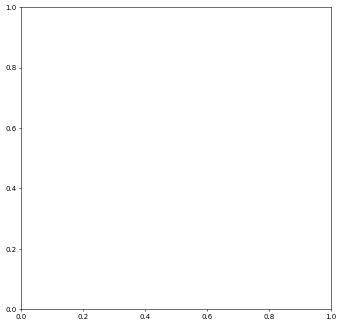

In [6]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *

import sys

class live_mode(QWidget):
    """
    This is my widget.
    """
    def __init__(self):
        super().__init__()
        
        self.global_layout = QGridLayout(self)
        
        #laser container
        containerl=QGroupBox("Laser Controls")
        layout=QHBoxLayout(containerl)
        
        self.laser=laser_widget(self)
        layout.addWidget(self.laser)
        containerl.setLayout(layout)
        
        self.global_layout.addWidget(containerl,0,0)
        
        
        #Data Acquisition
        containeracq=QGroupBox("Data Parameters")
        layout1=QHBoxLayout(containeracq)
        
        self.data=acquisition_widget(self)
        layout1.addWidget(self.data)
        containeracq.setLayout(layout1)
        
        self.global_layout.addWidget(containeracq,1,1)
        
        #camera
        containercam=QGroupBox("Camera")
        layout=QHBoxLayout(containercam)
        
        self.camera=camera_widget()
        layout.addWidget(self.camera)
        containercam.setLayout(layout)
        
        self.global_layout.addWidget(containercam,0,1)
        
        #piezo controls
        containerpiezo=QGroupBox("Piezo Controls")
        layout=QHBoxLayout(containerpiezo)
        
        self.piezo=piezo_widget(self)
        layout.addWidget(self.piezo)
        containerpiezo.setLayout(layout)
        
        self.global_layout.addWidget(containerpiezo,1,0)
        
    def closeEvent(self, event):
        self.laser.closeEvent(event)
        self.camera.closeEvent(event)
        self.piezo.closeEvent(event)
        event.accept()
        
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = live_mode()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

## Calibration Mode

In [7]:
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from pyqtgraph import PlotWidget, plot
import pyqtgraph as pg
import sys  # We need sys so that we can pass argv to QApplication
from DAQ import DAQ
import nidaqmx
from nidaqmx.stream_readers import AnalogMultiChannelReader
from nidaqmx.constants import AcquisitionType
import numpy as np
import os

import time


class calibration_mode(QWidget):
    """
    This is my widget.
    """
    
    def __init__(self):
        super().__init__()
        
        self.global_layout = QHBoxLayout(self)
        
        self.daq=DAQ()
        
        SizePolicy=QSizePolicy(QSizePolicy.Fixed,QSizePolicy.Fixed)
        
        #addons container
        containeradd=QGroupBox("Extra Controls")
        self.layout1=QVBoxLayout(containeradd)
        containeradd.setSizePolicy(SizePolicy)
        self.global_layout.addWidget(containeradd)
        
        
        #file name
        self.filelabel=QLabel(self)
        self.filelabel.setText('File Name')
        self.layout1.addWidget(self.filelabel)
        
        self.filename=QLineEdit(self)
        self.filename.setText('')
        self.layout1.addWidget(self.filename)
        
        #sample rate
        self.samplelabel=QLabel(self)
        self.samplelabel.setText('Sample Rate (kHz)')
        self.layout1.addWidget(self.samplelabel)
        
        self.samplerate=QLineEdit(self)
        self.samplerate.setText('')
        self.layout1.addWidget(self.samplerate)
        
        #self.samplerate.returnPressed.connect(self.update_sample_rate)
        
        #acquisition time
        self.acqlabel=QLabel(self)
        self.acqlabel.setText('Acquisition Time (s)')
        self.layout1.addWidget(self.acqlabel)
        
        self.acqtime=QLineEdit(self)
        self.acqtime.setText('')
        self.layout1.addWidget(self.acqtime)
        
        #button
        
        self.recording_button=QToolButton(self)
        self.recording_button.setText('Start Recording')
        self.layout1.addWidget(self.recording_button)
        self.recording_button.clicked.connect(self.start_reco)
        
        
        ##########################################################################################
        
        #graph container
        containergraph=QGroupBox("Data Recording")
        self.layout2=QVBoxLayout(containergraph)
        self.global_layout.addWidget(containergraph)
        
        # graph itself
        self.layout3=QVBoxLayout(self)
        
        self.graphWidget = pg.PlotWidget()
        
        self.layout3.addWidget(self.graphWidget)

        
        self.graphWidget.setBackground('w')
        
        self.graphWidget.showGrid(x = True, y = True, alpha = 1.0)

        pen = pg.mkPen(color=(255, 0, 0))
        pen1= pg.mkPen(color=(0, 255, 0))
        pen2= pg.mkPen(color=(0, 0, 255))
        self.data_line =  self.graphWidget.plot(np.array([]), pen=pen)
        self.data_line1 =  self.graphWidget.plot(np.array([]), pen=pen1)
        self.data_line2 =  self.graphWidget.plot(np.array([]), pen=pen2)
        
        self.layout2.addLayout(self.layout3)
        
        #buttons
        self.layout_buttons=QHBoxLayout(self)
        
        self.acq_button=QToolButton(self)
        self.acq_button.setText('Start Tracking')
        
        self.reset_button=QToolButton(self)
        self.reset_button.setText('Reset')
        
        self.acq_button.clicked.connect(self.button_pressed)
        self.layout_buttons.addWidget(self.acq_button)
        self.reset_button.clicked.connect(self.reset_d)
        self.layout_buttons.addWidget(self.reset_button)
        
        
        self.layout2.addLayout(self.layout_buttons)
        
    def thread_func(self):
        self.thread=QThread()
        self.worker=Worker_cal()
        self.worker.moveToThread(self.thread)
        self.thread.started.connect(self.worker.start_tracking)
        self.worker.finished.connect(self.thread.quit)
        self.worker.finished.connect(self.worker.deleteLater)
        self.thread.finished.connect(self.thread.deleteLater)
        self.worker.data.connect(self.update_plot_data)
        self.thread.start()
    
    def update_plot_data(self,data_retrieved):
        self.data_line.setData(data_retrieved[0])
        self.data_line1.setData(data_retrieved[1])
        self.data_line2.setData(data_retrieved[2])# Update the data
        
    def reset_d(self):
        self.data_line.setData(np.array([]))
        self.data_line1.setData(np.array([]))
        self.data_line2.setData(np.array([]))
    
    def button_pressed(self):
        if self.acq_button.text()=='Stop Tracking':
            self.acq_button.setText('Start Tracking')
            self.daq.task.close()
            self.worker.stop()
            self.thread.exit()
        else:
            self.daq=DAQ()
            self.thread_func()
            self.acq_button.setText('Stop Tracking')
            print(self.acq_button.text())
    
    def start_reco(self):
        self.worker.rec_start(int(self.acqtime.text()),int(self.samplerate.text()),self.filename.text())
    
    def closeEvent(self, event):
        self.worker.stop()
        self.thread.exit()
        event.accept()
        
class Worker_cal(QWidget):
    finished=pyqtSignal()
    data=pyqtSignal(np.ndarray)
    
    def __init__(self,acq=4,sr=10,file='a'):
        super(Worker_cal,self).__init__()
        self.daq=DAQ()
        self.acq=acq
        self.sr=sr*1000
        self.file=file
        self.rec_flag=False
        self.data_rec=np.empty([3, 1])
        self.n_points=self.sr*self.acq
        self.i=0
        
    
    def callback(self,task_handle, every_n_samples_event_type,number_of_samples, callback_data):
        data_out = np.empty(shape=(3, number_of_samples))
        self.reader.read_many_sample(data_out,number_of_samples)
        self.data.emit(data_out)
        
        if self.rec_flag==True:
            self.i+=number_of_samples
            np.savetxt(self.filei, np.column_stack(data_out),delimiter='\t')
            self.filei.write("\n")
            
            if self.i==self.n_points:
                self.filei.close()
                self.rec_flag=False
                print('Done')
            
        return 0
    
    def start_tracking(self):
        self.daq.task.timing.cfg_samp_clk_timing(rate=self.sr,
                                                 sample_mode=AcquisitionType.CONTINUOUS,
                                                samps_per_chan=self.n_points)
        
        
        self.reader = AnalogMultiChannelReader(self.daq.task.in_stream)
        self.daq.task.register_every_n_samples_acquired_into_buffer_event(1000,self.callback)
        self.daq.task.start()
        
        
    def file_save(self,filename,sr):
        default_dir =""
        default_filename = os.path.join(default_dir, filename)
        filepath, _ = QFileDialog.getSaveFileName(self, "Save file", default_filename, "(*.dat)")
        self.filei = open(filepath,'a')
        self.filei.write('Samples per channel: ' + str(sr) +'\nX\tY\tSUM\n')
        
    
    def start(self):
        self.flag=True
        
    def stop(self):
        self.finished.emit()
        self.daq.task.stop()
        self.daq.task.close()
        self.flag=False
        
    def rec_start(self,acq,sr,file):
        self.acq=acq
        self.sr=sr*1000
        self.file=file
        self.file_save(self.file,self.sr)
        self.rec_flag=True
                  
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    
if __name__ == "__main__": 
    #start the widget
    ui = calibration_mode()
    #show the widget
    ui.show()
    #start the events loop
    qapp.exec_()

AttributeError: 'calibration_mode' object has no attribute 'worker'

# Main Window

trap index [529 569]
Detecetd devices... ['29500489', '29500495', '29500501', '69250571', '84868288', '84868295']
Establishing connection...
Device 29500489 has been connected!
Device 29500495 has been connected!
Thorlabs.MotionControl.DeviceManagerCLI.SingleDeviceInfo


IndexError: index out of range

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1bea80b3460>


Full: 

Stop Tracking


C:\Users\INESC\anaconda3\envs\venvj\lib\site-packages\nidaqmx\task.py:97: ResourceWarning: Task of name "_unnamedTask<0>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
C:\Users\INESC\anaconda3\envs\venvj\lib\site-packages\nidaqmx\task.py:97: ResourceWarning: Task of name "_unnamedTask<1>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1beaa2b9220>


Thread Closed

Serial port closed
Piezo voltage before closing: (0.0251777703176977, 0.0778221991637928) V
Disconnected device 29500489
Disconnected device 29500495
Closed, bby!


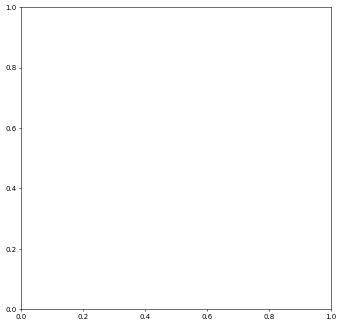

In [8]:
#interface 2.0
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
#import breeze_resources
import sys

class interface(QWidget):
    """
    This is my widget.
    """
    def __init__(self):
        super().__init__()
        
        self.setWindowTitle("Ferdinand")
        
        #layout principal
        self.global_layout = QHBoxLayout(self)
        
        #initiate tabs
        self.live=live_mode()
        self.calibration=calibration_mode()
        
        
        self.tabs = QTabWidget()
        self.tab1 = QWidget()
        self.tab2 = QWidget()
        self.tab3 = QWidget()
        self.tab4 = QWidget()
        
        self.tabs.addTab(self.tab1,"Live Mode")
        self.tabs.addTab(self.tab2,"Calibration Mode")
        self.tabs.addTab(self.tab3,"Classification Mode")
        self.tabs.addTab(self.tab4,"Settings")        
        
        #tab1- Live mode
        
        self.tab1.layout = QHBoxLayout(self)
        self.tab1.layout.addWidget(self.live)
        self.tab1.setLayout(self.tab1.layout)
        self.global_layout.addWidget(self.tabs)
        self.setLayout(self.global_layout)
        
        #tab2- Calibration Mode
        self.tab2.layout = QHBoxLayout(self)
        self.tab2.layout.addWidget(self.calibration)
        self.tab2.setLayout(self.tab2.layout)
        self.global_layout.addWidget(self.tabs)
        self.setLayout(self.global_layout)
        
        
    def closeEvent(self, event):
        close = QMessageBox.question(self,"Quit","Are you sure want to stop process?",QMessageBox.Yes | QMessageBox.No)
        if close == QMessageBox.Yes:
            self.live.closeEvent(event)
            event.accept()
        else:
            event.ignore()
        
###################################################################
qapp = QCoreApplication.instance()
if qapp is None:
    qapp = QApplication(sys.argv)
    file = QFile(":/dark/stylesheet.qss")
    file.open(QFile.ReadOnly | QFile.Text)
    stream = QTextStream(file)
    qapp.setStyleSheet(stream.readAll())
    
if __name__ == "__main__": 
    #start the widget
    ui = interface()
    #show the widget
    ui.show()
    #start the event loop
    qapp.exec_()